# Sleep Prediction
Here we try to use environmental parameters in addition to mood and activity characteristics to see if we are able to predict sleep quality.

## Features
In this analysis, we are going to consider the following features:
1. **Acitivity**: The main metrics for activity that we will use are:
    * Daily Steps
    * Intensity Levels
2. **Mood**: We have five metrics for mood:
    * Content
    * Lonely
    * Sadness
    * Stress
    * Energy Level 
3. **IEQ**: There are many measurements of IEQ that we consider:
    * CO$_2$
    * CO
    * PM$_{2.5}$
    * NO$_2$
    * TVOCs
    * Temperature
    * Relative Humidity
    
## Targets
The targets will be all metrics related to sleep quality:
1. **Self-Report**: There are four metrics for self-report sleep quality reported via EMA:
    * TST
    * SOL
    * NAW
    * Restfulness
2. **Fitbit-Measured**: There are also four metrics of sleep quality that we can use from Fitbit:
    * TST
    * SE
    * REM Percentage
    * Light Percentage
    * Deep Percentage

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# general
import os
import sys
sys.path.append('../')
# user-defined functions
from src.visualization import visualize
# basic data science
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
# timeseries
from datetime import datetime, timedelta
# plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

# Table of Contents
1. [Data Import](#data-import)
3. [Target Encoding](#encoding)
4. [Feature Engineering](#feature_engineering)
5. [Prediction](#prediction)
    1. [Fitbit Sleep Targets](#fitbit-sleep-prediction)
        1. TST
        2. SOL
        3. WASO
        4. REM:nREM
        5. SE
    2. [Self-Report Sleep Targets](#self-report-sleep-prediction)
        1. TST
        2. SOL
        3. NAW
        4. Restfulness
6. [Prediction with Encoded Features](#prediction_encoded)
7. [Final Analysis](#final_analysis)

<a id="data-import"></a>

# Data Import
For this analysis we want to only consider nights when we have _all_ the available data. These are also the nights that we have confirmed participants are home according to GPS traces. 

## Feature: IEQ
We start with IEQ data beacuse from previous analysis, this dataset has already been curated to include the relevant nights. However, there are quite a few columns that are not necessary for this analysis that have to be removed.

In [3]:
ieq_raw = pd.read_csv("../data/processed/beacon-fb_and_gps_filtered_summary-ux_s20.csv",parse_dates=["start_time","end_time"],infer_datetime_format=True)
ieq_raw["date"] = pd.to_datetime(ieq_raw["end_time"].dt.date)
ieq = ieq_raw[["start_time","end_time","date","beiwe","redcap","beacon","co2_median","co_median","pm2p5_mass_median","no2_median","temperature_c_median","rh_median"]]
ieq.rename({"date":"end_date"},axis="columns",inplace=True)
ieq.head()

,start_time,end_time,end_date,beiwe,redcap,beacon,co2_median,co_median,pm2p5_mass_median,no2_median,temperature_c_median,rh_median
0,2020-08-10 04:42:30,2020-08-10 12:35:30,2020-08-10,lkkjddam,12,21,1600.754959,10.359917,1.848583,1.593768,23.337500,33.0
1,2020-08-11 03:35:00,2020-08-11 12:36:30,2020-08-11,lkkjddam,12,21,1628.474180,6.429275,1.655522,1.597845,25.000000,34.0
2,2020-08-12 02:59:30,2020-08-12 10:52:30,2020-08-12,lkkjddam,12,21,1596.122408,10.271850,2.024990,1.603469,24.000000,33.0
3,2020-08-14 03:05:00,2020-08-14 11:23:30,2020-08-14,lkkjddam,12,21,1301.449844,7.232700,1.812659,1.592935,25.000000,33.0
4,2020-08-15 06:51:30,2020-08-15 11:30:00,2020-08-15,lkkjddam,12,21,1274.110350,10.886100,2.457356,1.606745,23.333333,34.0


## Feature: Activity
Activity data are essentially untouched from the raw format

In [4]:
activity_raw = pd.read_csv("../data/processed/fitbit-daily-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
activity = activity_raw[["timestamp","beiwe","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"]]
activity.rename({"timestamp":"date"},axis="columns",inplace=True)
activity.head()

,date,beiwe,steps,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes
0,2020-05-13,hfttkth7,9207,1241,70,118,11
1,2020-05-14,hfttkth7,15207,614,263,134,23
2,2020-05-15,hfttkth7,14556,577,205,57,108
3,2020-05-16,hfttkth7,18453,760,176,24,151
4,2020-05-17,hfttkth7,15425,605,207,50,131


## Feature: Mood
We only want to consider mood data from the latest survey prior to the participant going to sleep so we only important the evening EMAs.

In [5]:
mood = pd.read_csv("../data/processed/beiwe-evening_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
mood["date"] = pd.to_datetime(mood["timestamp"].dt.date)
mood.head()

,timestamp,beiwe,content,stress,lonely,sad,energy,redcap,beacon,date
0,2020-05-13 19:00:23,awa8uces,1.0,1.0,1.0,3.0,2.0,28,26.0,2020-05-13
1,2020-05-13 19:21:32,lkkjddam,0.0,2.0,3.0,1.0,0.0,12,21.0,2020-05-13
2,2020-05-13 19:30:38,rvhdl2la,2.0,1.0,0.0,0.0,1.0,29,NaN,2020-05-13
3,2020-05-13 20:07:04,xxvnhauv,1.0,3.0,1.0,2.0,0.0,21,22.0,2020-05-13
4,2020-05-13 20:25:07,xdbdrk6e,2.0,1.0,2.0,1.0,3.0,23,24.0,2020-05-13


## Target: Self-Report Sleep Quality (SRSQ)
The self-reported sleep quality comes from the morning EMAs.

In [6]:
srsq_raw = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
srsq_raw["date"] = pd.to_datetime(srsq_raw["timestamp"].dt.date)
srsq = srsq_raw[["timestamp","date","beiwe","redcap","beacon","tst","sol","naw","restful"]]
srsq.rename({"date":"end_date"},axis="columns",inplace=True)
srsq.head()

,timestamp,end_date,beiwe,redcap,beacon,tst,sol,naw,restful
0,2020-05-13 09:10:27,2020-05-13,qh34m4r9,68,19.0,8.0,20.0,2.0,3.0
1,2020-05-13 09:15:49,2020-05-13,awa8uces,28,26.0,2.0,10.0,3.0,1.0
2,2020-05-13 09:42:19,2020-05-13,xxvnhauv,21,22.0,6.0,30.0,3.0,1.0
3,2020-05-13 09:43:27,2020-05-13,rvhdl2la,29,NaN,5.3,5.0,2.0,2.0
4,2020-05-13 10:11:51,2020-05-13,q5y11ytm,48,NaN,2.0,10.0,0.0,0.0


## Target: Fitbit Sleep Quality (FBSQ)
Fitbit sleep summary data is imported below.

In [7]:
fbsq_raw = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time","start_date","end_date"],infer_datetime_format=True)
fbsq = fbsq_raw[["start_time","end_time","start_date","end_date","beiwe","redcap","beacon","tst_fb","efficiency","rem_percent","light_percent","deep_percent"]]
fbsq.rename({"tst_fb":"tst","efficiency":"se"},axis="columns",inplace=True)
fbsq.head()

,start_time,end_time,start_date,end_date,beiwe,redcap,beacon,tst,se,rem_percent,light_percent,deep_percent
0,2020-05-14 00:27:00,2020-05-14 07:13:00,2020-05-14,2020-05-14,hfttkth7,NaN,NaN,6.316667,93.349754,0.216359,0.562005,0.221636
1,2020-05-14 23:53:30,2020-05-15 08:06:30,2020-05-14,2020-05-15,hfttkth7,NaN,NaN,6.533333,79.513185,0.119898,0.637755,0.242347
2,2020-05-15 23:28:00,2020-05-16 04:57:00,2020-05-15,2020-05-16,hfttkth7,NaN,NaN,4.783333,87.234043,0.174216,0.662021,0.163763
3,2020-05-17 02:01:30,2020-05-17 09:28:30,2020-05-17,2020-05-17,hfttkth7,NaN,NaN,6.716667,90.156600,0.205955,0.600496,0.193548
4,2020-05-18 00:24:00,2020-05-18 07:20:00,2020-05-18,2020-05-18,hfttkth7,NaN,NaN,5.850000,84.375000,0.250712,0.475783,0.273504


## Target: Combined Sleep Quality (CSQ)
The sleep quality dataset has already been created from a previous analysis so we simply just have to import it.

I don't think we will be using this dataset, but we might as well keep it here.

In [8]:
sleep_quality = pd.read_csv("../data/processed/beiwe_fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time","start_date","end_date","date"],infer_datetime_format=True)
csq = sleep_quality[["start_time","end_time","start_date","end_date","date","beiwe","redcap","beacon","tst_ema","sol_ema","naw_ema","restful_ema","tst_fb","efficiency","rem_percent","nrem_percent"]]
csq.head() # Combined Sleep Quality (csq)

,start_time,end_time,start_date,end_date,date,beiwe,redcap,beacon,tst_ema,sol_ema,naw_ema,restful_ema,tst_fb,efficiency,rem_percent,nrem_percent
0,2020-05-14 01:06:00,2020-05-14 11:39:30,2020-05-14,2020-05-14,2020-05-14,15tejjtw,45.0,NaN,9.0,30.0,5.0,2.0,8.766667,83.096367,0.231939,0.768061
1,2020-05-16 02:19:00,2020-05-16 10:00:30,2020-05-16,2020-05-16,2020-05-16,15tejjtw,45.0,NaN,9.0,15.0,2.0,2.0,6.600000,85.900217,0.123737,0.876263
2,2020-05-17 00:27:00,2020-05-17 10:28:00,2020-05-17,2020-05-17,2020-05-17,15tejjtw,45.0,NaN,9.0,30.0,1.0,2.0,8.850000,88.352745,0.254237,0.745763
3,2020-05-18 01:37:00,2020-05-18 10:59:30,2020-05-18,2020-05-18,2020-05-18,15tejjtw,45.0,NaN,9.0,25.0,2.0,1.0,7.966667,85.053381,0.207113,0.792887
4,2020-05-21 23:59:30,2020-05-22 09:27:30,2020-05-21,2020-05-22,2020-05-22,15tejjtw,45.0,NaN,9.0,20.0,2.0,2.0,8.316667,87.852113,0.264529,0.735471


<a id="encoding" ></a>

# Target Encoding
We will encode all the target sleep quality variables as binary where 0 represents poor/negative outcomes and 1 are good/positive outcomes.

## SE
Based on a discussion with Dr. Schnyer, he suggested this scale (with some minor tweaks in language from me):

| SE | Rating | Value |
| --- | --- | --- |
| >90% | Excellent | 3 |
| 85% - 90% | Good | 2 |
| 80% - 85% | Typical | 1 |
| <80% | Poor | 0 |

Here, we just say the SE is good (1) when above 85%, otherwise it is bad (0).

In [9]:
def encode_se(value):
    """returns encoded value for se"""
    if value >= 85:
        return 1
    else:
        return 0

## TST
Based on a "traditional" recommendations, we can lump `tst` into three categories:

| TST | Rating | Value |
| --- | --- | --- |
| >9 h | High | 0 |
| 7-9 h | Typical | 1 |
| <7 h | Low | 0 |

In [10]:
def encode_tst(value):
    """returns score of tsts"""
    if value > 9:
        return 0
    elif value >= 7:
        return 1
    else:
        return 0

## REM
Ideally you should be spending between 20% and 25% of your night in REM sleep.

In [11]:
def encode_rem(value):
    """returns score of REM percent"""
    if value >= 0.2 and value <= 0.25:
        return 1
    else:
        return 0

## Light Sleep
Light Sleep should be a maximum of about 60% but we also don't want too little. 

In [12]:
def encode_light(value):
    """returns score of light percent"""
    if value >= 0.4 and value <= 0.6:
        return 1
    else:
        return 0

## Deep Sleep
Deep sleep should encompass about 12% to 23% of your night.

In [13]:
def encode_deep(value):
    """returns score of deep percent"""
    if value >= 0.12 and value <= 0.23:
        return 1
    else:
        return 0

## SOL
The National Sleep Foundation says 30 minutes or less is a marker for good sleep quality.

In [14]:
def encode_sol(value):
    """returns score of sol"""
    if value < 30:
        return 1
    else:
        return 0

## NAW
We group NAW into a good and bad category based on [Ohayon et al., 2017](https://www.sciencedirect.com/science/article/pii/S2352721816301309?casa_token=56p9duOGsL4AAAAA:tmPWLtzq0Z9zGGq-w0qWBXJT-VEDeoZ0dOwL06G-BwbWMHA3uT_KBjxd08HPyFZWNqIpm_0m).

| NAW | Rating | Value |
| --- | --- | --- |
| 0 or 1 | Good | 1 |
| >1 | Bad | 0 |

In [15]:
def encode_naw(value):
    """returns score of naw"""
    if value < 2:
        return 1
    else:
        return 0

## Restfulness
Restfulness is one of the five metrics that is rated on a 0 to 3 Likert scale. So we can create a more generic function here for later use.

In [16]:
def encode_likert(value):
    """returns score for a 0-3 Likert measurement"""
    if value > 1:
        return 1
    else:
        return 0

## Encoding Sleep Quality

### Self-Report Sleep
We start with self-report metrics of sleep quality.

In [17]:
for sm, f in zip(["tst","sol","naw","restful"], [encode_tst,encode_sol,encode_naw,encode_likert]):
    srsq[f"{sm}_binary"] = srsq.apply(lambda x: f(x[sm]), axis="columns")
    
srsq.head()

,timestamp,end_date,beiwe,redcap,beacon,tst,sol,naw,restful,tst_binary,sol_binary,naw_binary,restful_binary
0,2020-05-13 09:10:27,2020-05-13,qh34m4r9,68,19.0,8.0,20.0,2.0,3.0,1,1,0,1
1,2020-05-13 09:15:49,2020-05-13,awa8uces,28,26.0,2.0,10.0,3.0,1.0,0,1,0,0
2,2020-05-13 09:42:19,2020-05-13,xxvnhauv,21,22.0,6.0,30.0,3.0,1.0,0,0,0,0
3,2020-05-13 09:43:27,2020-05-13,rvhdl2la,29,NaN,5.3,5.0,2.0,2.0,0,1,0,1
4,2020-05-13 10:11:51,2020-05-13,q5y11ytm,48,NaN,2.0,10.0,0.0,0.0,0,1,1,0


### Fitbit Sleep
And now Fitbit-measured sleep quality.

In [18]:
for sm, f in zip(["tst","se","rem_percent","light_percent","deep_percent"], [encode_tst,encode_se,encode_rem,encode_light,encode_deep]):
    fbsq[f"{sm}_binary"] = fbsq.apply(lambda x: f(x[sm]), axis="columns")
    
fbsq.head()

,start_time,end_time,start_date,end_date,beiwe,redcap,beacon,tst,se,rem_percent,light_percent,deep_percent,tst_binary,se_binary,rem_percent_binary,light_percent_binary,deep_percent_binary
0,2020-05-14 00:27:00,2020-05-14 07:13:00,2020-05-14,2020-05-14,hfttkth7,NaN,NaN,6.316667,93.349754,0.216359,0.562005,0.221636,0,1,1,1,1
1,2020-05-14 23:53:30,2020-05-15 08:06:30,2020-05-14,2020-05-15,hfttkth7,NaN,NaN,6.533333,79.513185,0.119898,0.637755,0.242347,0,0,0,0,0
2,2020-05-15 23:28:00,2020-05-16 04:57:00,2020-05-15,2020-05-16,hfttkth7,NaN,NaN,4.783333,87.234043,0.174216,0.662021,0.163763,0,1,0,0,1
3,2020-05-17 02:01:30,2020-05-17 09:28:30,2020-05-17,2020-05-17,hfttkth7,NaN,NaN,6.716667,90.156600,0.205955,0.600496,0.193548,0,1,1,0,1
4,2020-05-18 00:24:00,2020-05-18 07:20:00,2020-05-18,2020-05-18,hfttkth7,NaN,NaN,5.850000,84.375000,0.250712,0.475783,0.273504,0,0,0,1,0


<a id="feature_engineering" ></a>

# Feature Engineering
In the following cells, we encode the various features to binary outcomes and combine the features into one dataset. 

## Encoding
We encode each of the features into a binary outcome.

### Activity

#### Activity Level
Encoding the activity levels can be accomplished by looking at recommendations from the American College of Sports Medicine. ACSM states that adults should do:
* Moderate Intensity: 150 - 300 minutes per week, or
* Vigorous: 75 - 150 minutes per week, or
* Combination

Fitbit divides activity level into multiple categories that are not exactly the same label as what the ACSM states. While the cutoff points are not very clear, they are most likely:
* Sedentary: MET < 1
* Light: MET < 3
* Fairly: MET < 6 (ACSM Moderate)
* Very: > 6 (ACSM Vigorous)

We look on a per-day basis so the cutoffs discussed above can be altered:
* Moderate: 21 - 43 minutes per day
* Vigorous: 11 - 21 minutes per day

We will start with what seems the most straightforward separation: getting enough moderate and vigorous activity per day. Based on the guidelines, one needs twice as many moderate minutes as vigorous minutes of activity. In order to address the "combination" category, we can multiply the number of vigorous minutes by 2 and add this value to the moderately active minutes which will allow us to compare this value to the moderately active minutes threshold. 

In [19]:
def encode_activity_level(row, moderate_threshold=21):
    """returns score of activity level"""
    if row["fairly_active_minutes"] + row["very_active_minutes"]*2 > moderate_threshold:
        return 1
    else:
        return 0

#### Number of Steps
An attainable goal that all adults should strive for is about 10,000 steps a day

In [20]:
def econde_steps(value):
    if value > 10000:
        return 1
    else:
        return 0

In [21]:
activity["active_binary"] = activity.apply(lambda row: encode_activity_level(row), axis="columns")
activity["steps_binary"] = activity.apply(lambda x: econde_steps(x["steps"]), axis="columns")
activity.head()

,date,beiwe,steps,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,active_binary,steps_binary
0,2020-05-13,hfttkth7,9207,1241,70,118,11,1,0
1,2020-05-14,hfttkth7,15207,614,263,134,23,1,1
2,2020-05-15,hfttkth7,14556,577,205,57,108,1,1
3,2020-05-16,hfttkth7,18453,760,176,24,151,1,1
4,2020-05-17,hfttkth7,15425,605,207,50,131,1,1


### Mood
Each of the mood scores (except for `energy`) are on the same Likert scale as `restful` so we can just use that function to encode the mood scores. For `energy`, there are only two negative responses so we will consider the `Neutral` response as a positive score which allows us to use the same function.

In [22]:
for variable in ["content","stress","lonely","sad","energy"]:
    mood[f"{variable}_binary"] = mood.apply(lambda x: encode_likert(x[variable]), axis="columns")
    
mood.head()

,timestamp,beiwe,content,stress,lonely,sad,energy,redcap,beacon,date,content_binary,stress_binary,lonely_binary,sad_binary,energy_binary
0,2020-05-13 19:00:23,awa8uces,1.0,1.0,1.0,3.0,2.0,28,26.0,2020-05-13,0,0,0,1,1
1,2020-05-13 19:21:32,lkkjddam,0.0,2.0,3.0,1.0,0.0,12,21.0,2020-05-13,0,1,1,0,0
2,2020-05-13 19:30:38,rvhdl2la,2.0,1.0,0.0,0.0,1.0,29,NaN,2020-05-13,1,0,0,0,0
3,2020-05-13 20:07:04,xxvnhauv,1.0,3.0,1.0,2.0,0.0,21,22.0,2020-05-13,0,1,0,1,0
4,2020-05-13 20:25:07,xdbdrk6e,2.0,1.0,2.0,1.0,3.0,23,24.0,2020-05-13,1,0,1,0,1


### IEQ
For the IEQ data, we want to determine whether the concentrations are low or high depending on the participant's own environment. So the process will involve looking at each of the IEQ measurements from each participant, finding the mean of those nights, and then determining 1 (low) or 0 (high).

In [23]:
def encode_ieq(value, threshold):
    """Scores the IEQ parameter"""
    if value <= threshold:
        return 1
    else:
        return 0

In [24]:
ieq_bi = pd.DataFrame()
stat="median"
for pt in ieq["beiwe"].unique():
    ieq_pt = ieq[ieq["beiwe"] == pt]
    for pollutant in ["co2", "co","pm2p5_mass","no2","temperature_c","rh"]:
        mean_night = np.nanmean(ieq_pt[f"{pollutant}_{stat}"])
        ieq_pt[f"{pollutant}_{stat}_binary"] = ieq_pt.apply(lambda x: encode_ieq(x[f"{pollutant}_{stat}"],mean_night), axis="columns")
        
    ieq_bi = ieq_bi.append(ieq_pt)
    
ieq_bi.head()

,start_time,end_time,end_date,beiwe,redcap,beacon,co2_median,co_median,pm2p5_mass_median,no2_median,temperature_c_median,rh_median,co2_median_binary,co_median_binary,pm2p5_mass_median_binary,no2_median_binary,temperature_c_median_binary,rh_median_binary
0,2020-08-10 04:42:30,2020-08-10 12:35:30,2020-08-10,lkkjddam,12,21,1600.754959,10.359917,1.848583,1.593768,23.337500,33.0,0,0,1,1,1,1
1,2020-08-11 03:35:00,2020-08-11 12:36:30,2020-08-11,lkkjddam,12,21,1628.474180,6.429275,1.655522,1.597845,25.000000,34.0,0,1,1,1,0,0
2,2020-08-12 02:59:30,2020-08-12 10:52:30,2020-08-12,lkkjddam,12,21,1596.122408,10.271850,2.024990,1.603469,24.000000,33.0,0,0,1,0,1,1
3,2020-08-14 03:05:00,2020-08-14 11:23:30,2020-08-14,lkkjddam,12,21,1301.449844,7.232700,1.812659,1.592935,25.000000,33.0,1,1,1,1,0,1
4,2020-08-15 06:51:30,2020-08-15 11:30:00,2020-08-15,lkkjddam,12,21,1274.110350,10.886100,2.457356,1.606745,23.333333,34.0,1,0,0,0,1,0


## Correcting EMA Timestamp
The EMAs are tricky because they can be submitted at any time. So we need to make sure that the `date` column we merge along corresponds to the correct end date of the Fitbit sleep event. 

In [25]:
def correct_ema_date(ema, fbs, threshold=3, verbose=True):
    """adds new column corresponding to the day when the participant woke"""
    ema_with_dates = pd.DataFrame()
    for pt in ema["beiwe"].unique():
        end_dates = []
        if verbose:
            print("Participant:", pt)
        # getting data per participant
        ema_pt = ema[ema["beiwe"] == pt]
        try:
            fb_pt = fbs[fbs["beiwe"] == pt]
        except KeyError:
            if verbose:
                print("\tNo Fitbit Data")
            continue
        # looping through submission times
        for submission_time in ema_pt["timestamp"]:
            end_dates.append(np.nan) # appending to keep same length
            fb_since = fb_pt[fb_pt["start_time"] > submission_time] # Fitbit sleep data since the EMA was submitted
            try:
                dt = fb_since["start_time"].iloc[0] - submission_time # get time difference between when the EMA was submitted and the Fitbit started logging data
            except IndexError:
                if verbose:
                    print("\tNo Fitbit Data after EMA submission of", submission_time.date())
                continue
            if dt < timedelta(hours=threshold): # if the EMA was submitted a certain time before the sleep event, add the actual date
                if submission_time.hour > 12:
                    end_dates[-1] = submission_time.date() + timedelta(days=1)
                else:
                    end_dates[-1] = submission_time.date()
                    
        ema_pt["end_date"] = pd.to_datetime(end_dates)
        if verbose:
            print((ema_pt["date"] == ema_pt["end_date"]).value_counts())
            print()
        ema_with_dates = ema_with_dates.append(ema_pt)
        
    return ema_with_dates

We get a new mood dataframe with the `end_date` column which we will merge along.

In [26]:
new_mood = correct_ema_date(mood, fbsq, threshold=5, verbose=False)

## Correcting Activity Date
The activity date corresponds to the day on which the participant was that active. Since all the other dates are relative to when the participant wakes up, we have to add a day to the activity data.

In [27]:
activity["end_date"] = activity["date"] + timedelta(days=1)

## Combining
Now that we have encoded all the target variables, we can combine them in different datasets to get a better sense of the available data for prediction. The common link between all the datasets will be the IEQ dataset since we are aiming to use those variables as a novel approach to prediction.

### IEQ Only
Considering the base case: just IEQ observations.

In [28]:
print("Number of observations:",len(ieq_bi))

Number of observations: 395


### Activity and IEQ

In [29]:
ieq_and_activity = ieq_bi.merge(right=activity,on=["end_date","beiwe"])
print("Number of observations:",len(ieq_and_activity))

Number of observations: 374


,start_time,end_time,end_date,beiwe,redcap,beacon,co2_median,co_median,pm2p5_mass_median,no2_median,temperature_c_median,rh_median,co2_median_binary,co_median_binary,pm2p5_mass_median_binary,no2_median_binary,temperature_c_median_binary,rh_median_binary,date,steps,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,active_binary,steps_binary
0,2020-08-10 04:42:30,2020-08-10 12:35:30,2020-08-10,lkkjddam,12,21,1600.754959,10.359917,1.848583,1.593768,23.337500,33.0,0,0,1,1,1,1,2020-08-09,7975,715,320,13,0,0,0
1,2020-08-11 03:35:00,2020-08-11 12:36:30,2020-08-11,lkkjddam,12,21,1628.474180,6.429275,1.655522,1.597845,25.000000,34.0,0,1,1,1,0,0,2020-08-10,6247,656,311,0,0,0,0
2,2020-08-12 02:59:30,2020-08-12 10:52:30,2020-08-12,lkkjddam,12,21,1596.122408,10.271850,2.024990,1.603469,24.000000,33.0,0,0,1,0,1,1,2020-08-11,18556,499,232,83,85,1,1
3,2020-08-14 03:05:00,2020-08-14 11:23:30,2020-08-14,lkkjddam,12,21,1301.449844,7.232700,1.812659,1.592935,25.000000,33.0,1,1,1,1,0,1,2020-08-13,6611,630,225,37,0,1,0
4,2020-08-15 06:51:30,2020-08-15 11:30:00,2020-08-15,lkkjddam,12,21,1274.110350,10.886100,2.457356,1.606745,23.333333,34.0,1,0,0,0,1,0,2020-08-14,14831,565,292,3,82,1,1


<div class="alert alert-block alert-success">
 
By including activity data, we only lose 21 observations from the original target dataset. This percent loss might even be smaller considering we haven't combined the data with the target datasets yet.
    
</div>

### Mood and IEQ

In [30]:
ieq_and_mood = ieq_bi.merge(right=new_mood,on=["end_date","beiwe","redcap","beacon"])
print("Number of observations:",len(ieq_and_mood))

Number of observations: 77


<div class="alert alert-block alert-danger">
 
Unfortunately the mood data is too sparsely represented and _dramatically_ reduces the amount of observations that we have.
    
</div>

### Activity, Mood, and IEQ

In [31]:
features_all = ieq_and_activity.merge(right=new_mood, on=["end_date","beiwe","redcap","beacon"])
print("Number of observations:",len(features_all))

Number of observations: 70


<div class="alert alert-block alert-danger">
 
Now looping in all three feature sets, we see that we only hae 70 observations to work with and this is before merging with the target datasets which would cut down our dataset even more. 
    
</div>

<a id="prediction"></a>

# Prediction
Now that we have sufficiently explored the features, we can begin to try predicting various components of sleep quality. 

In [69]:
def get_features_and_targets(feature_set, target_set, target="tst"):
    """gets feature set and target set for the same observations"""
    # selecting only important target
    target_set_reduced = target_set[["beiwe","end_date",f"{target}_binary"]]
    # combining datasets to get overlapping observations
    combined = feature_set.merge(right=target_set_reduced,on=["beiwe","end_date"])
    combined_simple = combined[[column for column in combined.columns if column.endswith("binary")]]
    # splitting into features and targets
    targets = combined_simple[[f"{target}_binary"]]
    features = combined_simple.drop([f"{target}_binary"],axis="columns")
    return features, targets

In [70]:
X, y = get_features_and_targets(ieq_bi,fbsq)

## Model Parameters
The majority of our target variables are continuous with the exception of `restful` and `se_rating`. For these variables, we will target a few regressors:
* Generalized Linear Regressor
* Support Vector Regression
* Random Forest Regression

In [241]:
from sklearn.linear_model import TweedieRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

For categorical outcomes, we will target three classifiers:
* Random Forest
* Naive-Bayes

In [242]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

## Prediction Class

In [338]:
class ieq_and_sq_prediction:
    
    def __init__(self, data, feature_list, target_list):
        self.feature_list = feature_list
        # definining targets/features
        self.data = data
        self.features = data[feature_list]
        self.targets = data[target_list]
        # defining classifier model parameters
        self.classifier_model_params = {
            "random_forest": {
                "model":RandomForestClassifier(random_state=42),
                "params": {
                    "n_estimators":[5,10,15,20,25],
                    "max_depth":[2,3,4,5],
                }
            },
            "gnb": {
                "model":GaussianNB(),
                "params": {
                }
            },
            "bnb": {
                "model":BernoulliNB(),
                "params": {
                }
            }
        }
        self.regressor_model_params = {
            "linear": {
                "model":TweedieRegressor(max_iter=5000),
                "params": {
                    "power":[0,1,2],
                }
            },
            "svr": {
                "model":SVR(),
                "params":{
                    "kernel":["poly","rbf"]
                }
            },
            "random_forest": {
                "model":RandomForestRegressor(),
                "params":{
                    "n_estimators":[5,10,15,20,25],
                    "max_depth":[2,3,4]
                }
            }
        }
    
    def target_summary(self, target):
        """prints out a summary of the targets"""
        for score in self.targets[target].unique():
            print(f"{score}: {len(self.targets[self.targets[target] == score])}")
            
    def split_data(self, target, scale=True):
        """splits the data into a training and testing set"""
        if scale:
            for column in self.features.columns:
                self.features[column] = (self.features[column] - self.features[column].min()) / (self.features[column].max() - self.features[column].min())
                
        try:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.features, self.targets[target], test_size=0.33, random_state=10, stratify=self.targets[target])
        except ValueError:
            print("Not a classifier")
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.features, self.targets[target], test_size=0.33, random_state=10)
    
    def optimize_models(self, model_type="classifier"):
        """runs gridsearch cv"""
        try:
            i = 1
            scores = []
            if model_type == "classifier":
                params = self.classifier_model_params
            else:
                params = self.regressor_model_params
            while i < len(self.feature_list)+1:
                for model_name, mp in params.items():
                    clf = GridSearchCV(mp["model"],mp["params"],cv=5,return_train_score=False)
                    clf.fit(self.X_train[self.feature_list[:i]],self.y_train)
                    scores.append({
                        "model":model_name,
                        "best_score":clf.best_score_,
                        "best_params":clf.best_params_,
                        "n_features":i
                    })
                i+=1

            results = pd.DataFrame(scores,columns=["model","best_score","best_params","n_features"])
            results.sort_values(["best_score"],ascending=False,inplace=True)
            print(f"Highest Scoring Model:")
            best = results.iloc[0,:]
            print(f"\tModel:\t{best[0]}\n\tScore:\t{round(best[1],3)}\n\tParameters:\t{best[2]}\n\tNumber of Features:\t{best[3]}")
            return results.sort_values(["model","n_features"])
        except AttributeError:
            print("Need to split the data first with split_data()")
    
    def train_model(self, model, features_to_include=[]):
        """trains the specified model"""
        self.model = model
        try:
            if len(features_to_include) > 0:
                self.X_train = self.X_train[features_to_include]
                self.X_test = self.X_test[features_to_include]
            self.model.fit(self.X_train,self.y_train)
        except AttributeError:
            print("Training data do not exist - run split_data()")
    
    def predict(self, model_type="classifier"):
        """gets the predicted results based on the model provided for the given target"""
        print(self.model)
        try:
            self.predictions = self.model.predict(self.X_test)
            if model_type == "classifier":
                self.score = metrics.precision_score(self.y_test,self.predictions,average="weighted")

                scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5, scoring='precision_weighted')
                print("Cross Validation Scores:")
                for scr in scores:
                    print(f"\t{scr}")
                print(f"Average:{scores.mean()}")
            else:
                self.score = metrics.r2_score(self.y_test,self.predictions)

            print(f"Model Score: {self.score}")
                
        except AttributeError:
            print("Missing attributes - make sure you split the data and trained the model")
        
    def plot_confusion_matrix(self, save=False, target_label=""):
        """plots confusion matrix"""
        # get confusion matrix
        cm = metrics.confusion_matrix(self.y_test,self.predictions)
        cm_df = pd.DataFrame(cm)
        # plot confusion matrix as heatmap
        fig, ax = plt.subplots(figsize=(5,4))
        sns.heatmap(cm_df,annot=True,cmap="Blues",ax=ax)
        ax.set_xlabel("Predicted Label",fontsize=16)
        ax.set_ylabel("True Label",fontsize=16)
        if save:
            plt.savefig(f"../../../Documents/sbac_2021/project/figures/confusion_matrix-{target_label}.pdf")
        plt.show()
        plt.close()
        
    def plot_correlation(self,):
        """Plots the correlation between prediction and true"""
        fig, ax = plt.subplots(figsize=(4,4))
        sns.regplot(x=self.y_test,y=self.predictions,ax=ax)
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)

        ax.set_xlabel("True Values",fontsize=16)

        ax.set_ylabel("Predictions",fontsize=16)

        r = np.corrcoef(self.y_test,self.predictions)
        ax.set_title(f"r$^2$: {round(r[1,0],2)}",fontsize=14)

        plt.show()
        plt.close()

<a id="fitbit-sleep-prediction"></a>

## Fitbit Sleep Targets
We start by trying to predict some of the Fitbit sleep metrics.

In [244]:
fb_prediction = ieq_and_sq_prediction(ieq_and_fb,[var for var in ieq_and_fb.columns if var.endswith("median")],["rem2nrem","rem2nrem_binary","tst_fb","tst_binary","waso","waso_binary","sol_fb","se_binary"])

### TST - Continuous

In [245]:
fb_prediction.split_data("tst_fb")
res = fb_prediction.optimize_models(model_type="reg")

Not a classifier
Highest Scoring Model:
	Model:	random_forest
	Score:	0.009
	Parameters:	{'max_depth': 3, 'n_estimators': 20}
	Number of Features:	2


RandomForestRegressor(max_depth=2, n_estimators=10)
Model Score: 0.002019733256371281


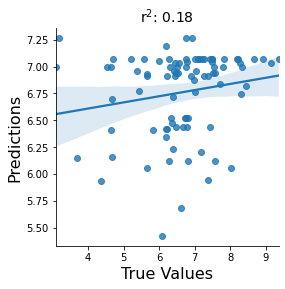

In [246]:
fb_prediction.train_model(RandomForestRegressor(max_depth=2,n_estimators=10),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median"])
fb_prediction.predict(model_type="reg")
fb_prediction.plot_correlation()

### TST - Binned
Looking at the TST values after binning into low (0), typical (1), and high (0) categories.

In [247]:
fb_prediction.split_data("tst_binary")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.692
	Parameters:	{'max_depth': 2, 'n_estimators': 20}
	Number of Features:	5


GaussianNB()
Cross Validation Scores:
	0.37345679012345684
	0.6561747506019953
	0.40040876997398744
	0.545578231292517
	0.6488721804511278
Average:0.5248981444886168
Model Score: 0.569261136676867


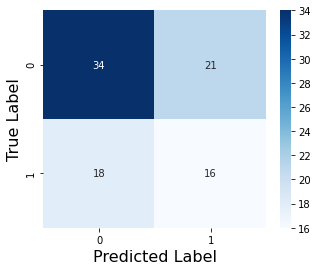

In [248]:
#fb_prediction.train_model(RandomForestClassifier(n_estimators=20,max_depth=2),features_to_include=["co2_median","rh_median","co_median","temperature_c_median"])
fb_prediction.train_model(GaussianNB(),features_to_include=["co2_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

### WASO - Continuous

In [249]:
fb_prediction.split_data("waso")
res = fb_prediction.optimize_models(model_type="reg")

Not a classifier
Highest Scoring Model:
	Model:	linear
	Score:	0.003
	Parameters:	{'power': 1}
	Number of Features:	6


RandomForestRegressor(max_depth=4, n_estimators=25)
Model Score: -0.06139176898330878


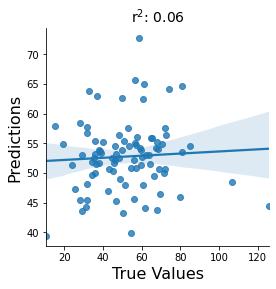

In [250]:
fb_prediction.train_model(RandomForestRegressor(max_depth=4,n_estimators=25),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median"])
fb_prediction.predict(model_type="reg")
fb_prediction.plot_correlation()

### WASO - Binned

In [251]:
fb_prediction.split_data("waso_binary")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.607
	Parameters:	{'max_depth': 5, 'n_estimators': 5}
	Number of Features:	2


RandomForestClassifier(max_depth=3, n_estimators=15)
Cross Validation Scores:
	0.40854978354978355
	0.48353909465020567
	0.5063492063492063
	0.6027972027972028
	0.5151260504201681
Average:0.5032722675533133
Model Score: 0.5341924157303372


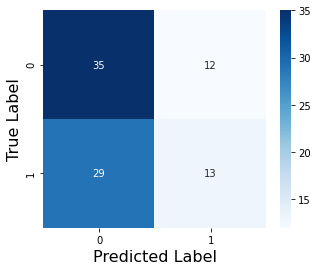

In [252]:
fb_prediction.train_model(RandomForestClassifier(max_depth=3,n_estimators=15),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median","pm2p5_mass_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

### REM:nREM - Continuous

In [253]:
fb_prediction.split_data("rem2nrem")
res = fb_prediction.optimize_models(model_type="reg")

Not a classifier
Highest Scoring Model:
	Model:	random_forest
	Score:	0.055
	Parameters:	{'max_depth': 3, 'n_estimators': 25}
	Number of Features:	6


SVR()
Model Score: 0.17957535546170378


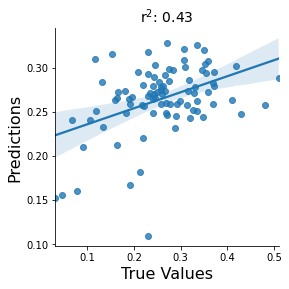

In [254]:
fb_prediction.train_model(SVR(kernel="rbf"),features_to_include=["co2_median","rh_median","co_median","temperature_c_median"])
fb_prediction.predict(model_type="reg")
fb_prediction.plot_correlation()

### REM:nREM - Binary

In [255]:
fb_prediction.split_data("rem2nrem_binary")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.59
	Parameters:	{'max_depth': 5, 'n_estimators': 20}
	Number of Features:	3


RandomForestClassifier(max_depth=4, n_estimators=10)
Cross Validation Scores:
	0.5
	0.42002063983488136
	0.6510416666666666
	0.5387755102040815
	0.6133333333333334
Average:0.5446342300077925
Model Score: 0.6044815342568152


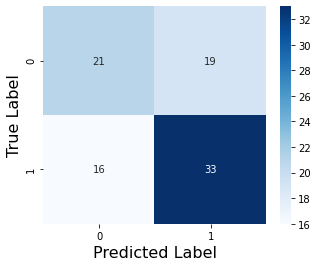

In [256]:
fb_prediction.train_model(RandomForestClassifier(max_depth=4,n_estimators=10),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

### Sleep Efficiency - Binned

In [257]:
fb_prediction.split_data("se_binary")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	bnb
	Score:	0.775
	Parameters:	{}
	Number of Features:	3


RandomForestClassifier(max_depth=3, n_estimators=10)
Cross Validation Scores:
	0.6049382716049383
	0.5892255892255892
	0.6631944444444444
	0.5657142857142856
	0.5785714285714286
Average:0.6003288039121373
Model Score: 0.5990806945863126


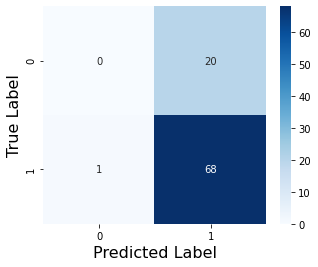

In [258]:
fb_prediction.train_model(RandomForestClassifier(n_estimators=10,max_depth=3),features_to_include=["co2_median","rh_median","temperature_c_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

<a id="self-report-sleep-prediction"></a>

## Self-Reports Sleep Targets

In [259]:
bw_prediction = ieq_and_sq_prediction(ieq_and_bw,[var for var in ieq_and_bw.columns if var.endswith("median")],["tst","tst_binary","sol","sol_binary","naw_binary","restful_binary"])

### TST - Continuous

In [260]:
bw_prediction.split_data("tst")
res = bw_prediction.optimize_models(model_type="reg")

Not a classifier
Highest Scoring Model:
	Model:	random_forest
	Score:	0.124
	Parameters:	{'max_depth': 4, 'n_estimators': 25}
	Number of Features:	6


RandomForestRegressor(max_depth=3, n_estimators=20)
Model Score: -0.025373514811966924


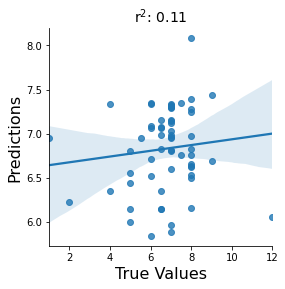

In [261]:
bw_prediction.train_model(RandomForestRegressor(max_depth=3,n_estimators=20),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median","pm2p5_mass_median"])
bw_prediction.predict(model_type="reg")
bw_prediction.plot_correlation()

### TST - Binned

In [262]:
bw_prediction.split_data("tst_binary")
res = bw_prediction.optimize_models()

Highest Scoring Model:
	Model:	gnb
	Score:	0.699
	Parameters:	{}
	Number of Features:	1


RandomForestClassifier(max_depth=4, n_estimators=15)
Cross Validation Scores:
	0.6885714285714286
	0.8016666666666667
	0.8016666666666667
	0.47222222222222215
	0.6031746031746031
Average:0.6734603174603175
Model Score: 0.45491803278688525


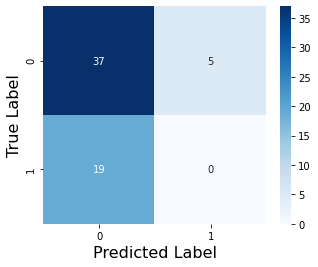

In [263]:
bw_prediction.train_model(RandomForestClassifier(max_depth=4,n_estimators=15),features_to_include=["co2_median","rh_median","co_median"])
bw_prediction.predict()
bw_prediction.plot_confusion_matrix()

### SOL - Binned

In [264]:
bw_prediction.split_data("sol_binary")
res = bw_prediction.optimize_models()

Highest Scoring Model:
	Model:	gnb
	Score:	0.813
	Parameters:	{}
	Number of Features:	6


RandomForestClassifier(max_depth=2, n_estimators=15)
Cross Validation Scores:
	0.5617391304347826
	0.5776
	0.5776
	0.626736111111111
	0.5625
Average:0.5812350483091787
Model Score: 0.568664337543671


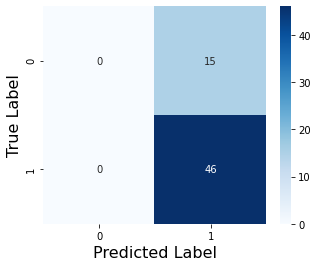

In [265]:
bw_prediction.train_model(RandomForestClassifier(max_depth=2,n_estimators=15),features_to_include=["co2_median"])
bw_prediction.predict()
bw_prediction.plot_confusion_matrix()

### NAW - Binned

In [266]:
bw_prediction.split_data("naw_binary")
res = bw_prediction.optimize_models()

Highest Scoring Model:
	Model:	gnb
	Score:	0.845
	Parameters:	{}
	Number of Features:	6


GaussianNB()
Cross Validation Scores:
	0.9284210526315789
	0.8704761904761905
	0.7952380952380953
	0.8333333333333334
	0.8523809523809524
Average:0.8559699248120302
Model Score: 0.7081254454739844


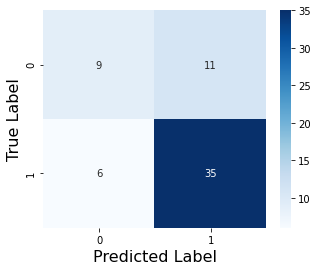

In [267]:
bw_prediction.train_model(GaussianNB(),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median","pm2p5_mass_median"])
bw_prediction.predict()
bw_prediction.plot_confusion_matrix()

### Restful

In [268]:
bw_prediction.split_data("restful_binary")
res = bw_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.878
	Parameters:	{'max_depth': 5, 'n_estimators': 20}
	Number of Features:	6


RandomForestClassifier(max_depth=2, n_estimators=20)
Cross Validation Scores:
	0.7744
	0.7
	0.7056
	0.765625
	0.765625
Average:0.74225
Model Score: 0.8106418449569326


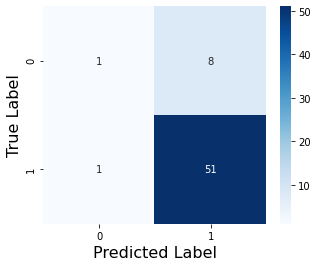

In [269]:
bw_prediction.train_model(RandomForestClassifier(max_depth=2,n_estimators=20),features_to_include=["co2_median","rh_median","co_median","temperature_c_median"])
bw_prediction.predict()
bw_prediction.plot_confusion_matrix()

<a id="prediction_encoded"></a>

# Prediction with Encoded Features
Here we repeat a large portion of the analysis, but considering features that have been encoded.

## Fitbit Sleep Targets

In [270]:
fb_prediction = ieq_and_sq_prediction(ieq_and_fb_binned,[var for var in ieq_and_fb_binned.columns if var.endswith("median")],["rem2nrem_binary","tst_binary","waso_binary","se_binary"])

### TST

In [271]:
fb_prediction.split_data("tst_binary")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	bnb
	Score:	0.63
	Parameters:	{}
	Number of Features:	5


RandomForestClassifier(max_depth=4, n_estimators=20, random_state=42)
Cross Validation Scores:
	0.6345224823485692
	0.4444444444444444
	0.5301075268817205
	0.5350529100529101
	0.5466666666666666
Average:0.5381588060788622
Model Score: 0.6408527801786229


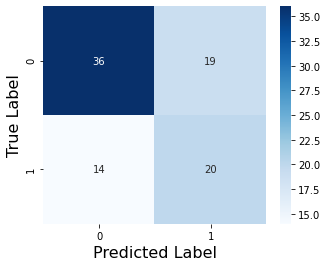

In [272]:
fb_prediction.train_model(RandomForestClassifier(max_depth=4,n_estimators=20,random_state=42),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

### REM:nREM

In [273]:
fb_prediction.split_data("rem2nrem_binary")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.601
	Parameters:	{'max_depth': 2, 'n_estimators': 25}
	Number of Features:	5


RandomForestClassifier(max_depth=3, n_estimators=10)
Cross Validation Scores:
	0.5462962962962963
	0.6172839506172839
	0.49682539682539684
	0.6074074074074074
	0.6674285714285714
Average:0.5870483245149911
Model Score: 0.5783029833397908


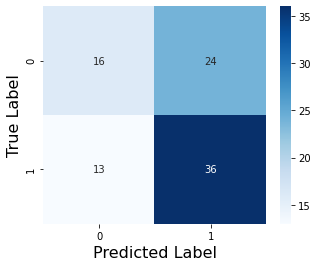

In [274]:
fb_prediction.train_model(RandomForestClassifier(max_depth=3,n_estimators=10),features_to_include=["co2_median","rh_median","co_median","temperature_c_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

### WASO

In [275]:
fb_prediction.split_data("waso_binary")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.562
	Parameters:	{'max_depth': 3, 'n_estimators': 10}
	Number of Features:	4


RandomForestClassifier(max_depth=3, n_estimators=4)
Cross Validation Scores:
	0.4409722222222222
	0.38359788359788355
	0.5727598566308243
	0.5892857142857143
	0.4
Average:0.4773231353473289
Model Score: 0.4751379854129706


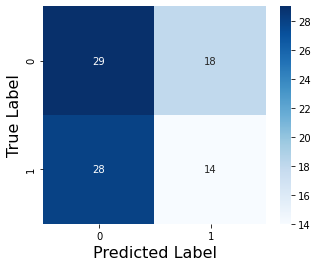

In [276]:
fb_prediction.train_model(RandomForestClassifier(max_depth=3,n_estimators=4),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

### Sleep Efficiency

In [277]:
fb_prediction.split_data("se_binary")
res = fb_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.775
	Parameters:	{'max_depth': 2, 'n_estimators': 5}
	Number of Features:	1


RandomForestClassifier(max_depth=4, n_estimators=25)
Cross Validation Scores:
	0.785663082437276
	0.8627450980392157
	0.7287581699346405
	0.6543778801843317
	0.6880131362889984
Average:0.7439114733768926
Model Score: 0.7628255378451354


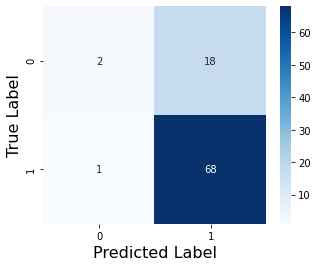

In [278]:
fb_prediction.train_model(RandomForestClassifier(max_depth=4,n_estimators=25),features_to_include=["co2_median","rh_median","co_median","temperature_c_median"])
fb_prediction.predict()
fb_prediction.plot_confusion_matrix()

## Beiwe Self-Report Sleep

In [279]:
bw_prediction = ieq_and_sq_prediction(ieq_and_bw_binned,[var for var in ieq_and_bw_binned.columns if var.endswith("median")],["tst_binary","sol_binary","restful_binary","naw_binary"])

### TST

In [280]:
bw_prediction.split_data("tst_binary")
res = bw_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.699
	Parameters:	{'max_depth': 2, 'n_estimators': 5}
	Number of Features:	1


RandomForestClassifier(max_depth=2, n_estimators=5, random_state=42)
Cross Validation Scores:
	0.5184
	0.46240000000000003
	0.46240000000000003
	0.5017361111111112
	0.5017361111111112
Average:0.48933444444444446
Model Score: 0.47406611126041387


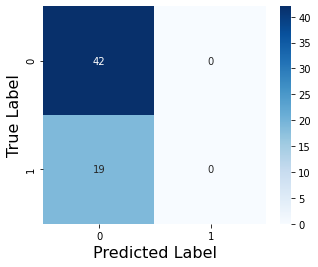

In [281]:
bw_prediction.train_model(RandomForestClassifier(max_depth=2,n_estimators=5,random_state=42),features_to_include=["co2_median"])
bw_prediction.predict()
bw_prediction.plot_confusion_matrix()

### SOL

In [282]:
bw_prediction.split_data("sol_binary")
res = bw_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.772
	Parameters:	{'max_depth': 3, 'n_estimators': 10}
	Number of Features:	4


RandomForestClassifier(max_depth=2, n_estimators=5, random_state=42)
Cross Validation Scores:
	0.5776
	0.5776
	0.5776
	0.626736111111111
	0.5625
Average:0.5844072222222223
Model Score: 0.568664337543671


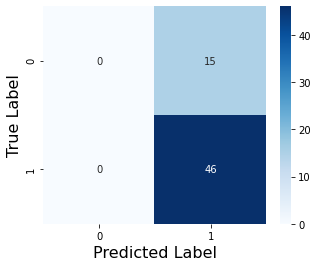

In [283]:
bw_prediction.train_model(RandomForestClassifier(max_depth=2,n_estimators=5,random_state=42),features_to_include=["co2_median"])
bw_prediction.predict()
bw_prediction.plot_confusion_matrix()

### Restful

In [284]:
bw_prediction.split_data("restful_binary")
res = bw_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.862
	Parameters:	{'max_depth': 2, 'n_estimators': 5}
	Number of Features:	1


In [285]:
res

,model,best_score,best_params,n_features
2,bnb,0.862000,{},1
5,bnb,0.854000,{},2
8,bnb,0.862000,{},3
11,bnb,0.854000,{},4
14,bnb,0.862000,{},5
1,gnb,0.862000,{},1
4,gnb,0.853667,{},2
7,gnb,0.853667,{},3
10,gnb,0.853667,{},4
13,gnb,0.853667,{},5


AdaBoostClassifier()
Cross Validation Scores:
	0.7744
	0.7056
	0.7056
	0.7556818181818182
	0.7608695652173912
Average:0.7404302766798418
Model Score: 0.7266863746304756


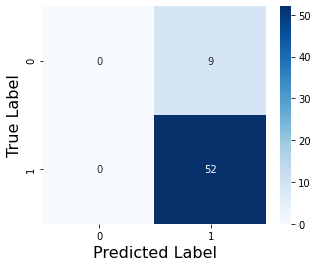

In [286]:
bw_prediction.train_model(AdaBoostClassifier(n_estimators=50),features_to_include=["co2_median","rh_median","co_median","temperature_c_median"])
bw_prediction.predict()
bw_prediction.plot_confusion_matrix()

### NAW

In [287]:
bw_prediction.split_data("naw_binary")
res = bw_prediction.optimize_models()

Highest Scoring Model:
	Model:	random_forest
	Score:	0.772
	Parameters:	{'max_depth': 3, 'n_estimators': 5}
	Number of Features:	5


RandomForestClassifier(max_depth=3, n_estimators=5, random_state=42)
Cross Validation Scores:
	0.92
	0.5447619047619047
	0.7353846153846155
	0.7185185185185187
	0.8055555555555555
Average:0.7448441188441188
Model Score: 0.7225668291242061


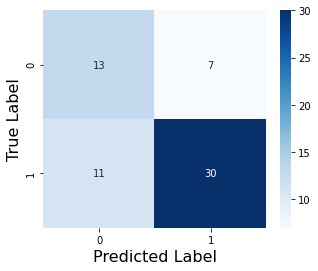

In [288]:
bw_prediction.train_model(RandomForestClassifier(max_depth=3,n_estimators=5,random_state=42),features_to_include=["co2_median","rh_median","co_median","temperature_c_median","tvoc_median"])
bw_prediction.predict()
bw_prediction.plot_confusion_matrix()

<a id="final_analysis"></a>

# Review on Current Analysis and Next Steps
After running curating the features and targets, training and tunining models, and predicting some sleep outcomes, I have come to a conclusion about which data are important to include from the feature and target datasets.

## Features
For features we will simply include:
* CO$_2$
* Relative Humidity
* Temperature

We choose to include these because `co2` will give us an indication of ventilation and therefore other pollutant concentrations while `temperature_c` and `rh` give insight into the thermal conditions in the space. These variables also ranked highly in PCA and we can trust their measurements.

## Targets
For targets, we will look at:
* Sleep Efficiency (Fitbit)
* REM:nREM (Fitbit)
* SOL (Beiwe)
* Restfulness (Beiwe)

The other target variables (`tst`, `waso`, and `naw`) are either not heavily affected by IEQ parameters or are more/less incorporated into the other metrics. 

For both datasets, we will be considering binned values i.e. no continuous measurements will be used, only categorical. 

## Artificial Weighting
Here we will consider weighting the unobserved variables by artificially introducing repeats of those observations. This should help the models predict the unobserved targets with better proficiency.

## Process
The following process will be conducted as a final analysis on the dataset:
1. 

In [289]:
ieq_and_fb_binned.head()

,tvoc_median,co_median,co2_median,temperature_c_median,rh_median,efficiency,rem2nrem,tst_fb,waso,sol_fb,wol_fb,se_rating,se_binary,tst_binary,waso_binary,rem2nrem_binary
0,1,0,0,1,0,83.932347,0.217791,6.616667,60.5,0.5,15.0,1,0,0,0,1
1,0,0,0,1,0,84.103512,0.256906,7.583333,85.0,1.0,0.0,1,0,1,0,1
2,0,0,0,1,0,86.257928,0.189504,6.800000,59.0,0.0,6.0,2,1,0,0,0
3,0,0,0,1,0,85.140562,0.218391,7.066667,61.5,1.0,11.5,2,1,1,0,1
4,0,0,0,1,0,83.093525,0.320000,3.850000,38.5,8.5,0.0,1,0,0,1,1


In [290]:
def get_artificial(df, target, val, features=["co2_median","rh_median","temperature_c_median"]):
    """Gets data to add to training set"""
    li = features + [target]
    temp = df[li]
    temp = temp[temp[target] == val]
    return temp

## IEQ and Fitbit Sleep Efficiency

### Inspecting

In [339]:
ieq_and_se = ieq_and_sq_prediction(ieq_and_fb_binned, feature_list=["co2_median","rh_median","temperature_c_median"], target_list=["se_binary"])
ieq_and_se.target_summary("se_binary")

0: 60
1: 207


### Artificially Increasing Low-Observed Target Values

In [340]:
add = get_artificial(ieq_and_fb_binned,"se_binary",0)
ieq_and_se.split_data("se_binary")
ieq_and_se.X_train = ieq_and_se.X_train.append(add[["co2_median","rh_median","temperature_c_median"]])
ieq_and_se.y_train = ieq_and_se.y_train.append(add["se_binary"])

### Modeling and Predicting

In [341]:
res = ieq_and_se.optimize_models()
res

Highest Scoring Model:
	Model:	random_forest
	Score:	0.68
	Parameters:	{'max_depth': 2, 'n_estimators': 5}
	Number of Features:	1


,model,best_score,best_params,n_features
2,bnb,0.679610,{},1
5,bnb,0.662943,{},2
8,bnb,0.662677,{},3
1,gnb,0.679610,{},1
4,gnb,0.679610,{},2
7,gnb,0.679610,{},3
0,random_forest,0.679610,"{'max_depth': 2, 'n_estimators': 5}",1
3,random_forest,0.679610,"{'max_depth': 2, 'n_estimators': 5}",2
6,random_forest,0.650443,"{'max_depth': 2, 'n_estimators': 5}",3


BernoulliNB()
Cross Validation Scores:
	0.7702403542061985
	0.6754385964912281
	0.8333333333333334
	0.5131251726996408
	0.5266924564796905
Average:0.6637659826420184
Model Score: 0.7369941708203093


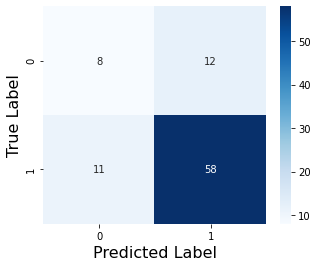

In [343]:
#ieq_and_se.train_model(RandomForestClassifier(max_depth=2,n_estimators=5),features_to_include=["co2_median","rh_median","temperature_c_median"])
#ieq_and_se.train_model(GaussianNB(),features_to_include=["co2_median","rh_median","temperature_c_median"])
ieq_and_se.train_model(BernoulliNB(),features_to_include=["co2_median","rh_median","temperature_c_median"])
ieq_and_se.predict()
ieq_and_se.plot_confusion_matrix(save=True,target_label="fb_se")

## IEQ and Fitbit REM:nREM Ratio

### Inspecting

In [344]:
ieq_and_r2r = ieq_and_sq_prediction(ieq_and_fb_binned, feature_list=["co2_median","rh_median","temperature_c_median"], target_list=["rem2nrem_binary"])
ieq_and_r2r.target_summary("rem2nrem_binary")

1: 146
0: 121


### Modeling and Predicting

In [345]:
ieq_and_r2r.split_data("rem2nrem_binary")
res = ieq_and_r2r.optimize_models()
res

Highest Scoring Model:
	Model:	random_forest
	Score:	0.618
	Parameters:	{'max_depth': 2, 'n_estimators': 20}
	Number of Features:	3


,model,best_score,best_params,n_features
2,bnb,0.567937,{},1
5,bnb,0.539841,{},2
8,bnb,0.585079,{},3
1,gnb,0.567937,{},1
4,gnb,0.551270,{},2
7,gnb,0.590794,{},3
0,random_forest,0.567937,"{'max_depth': 2, 'n_estimators': 5}",1
3,random_forest,0.556825,"{'max_depth': 2, 'n_estimators': 5}",2
6,random_forest,0.618095,"{'max_depth': 2, 'n_estimators': 20}",3


RandomForestClassifier(max_depth=2, n_estimators=20)
Cross Validation Scores:
	0.5462962962962963
	0.462962962962963
	0.7956989247311828
	0.6074074074074074
	0.6674285714285714
Average:0.615958832565284
Model Score: 0.5663048308258745


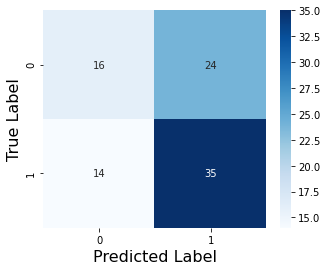

In [350]:
ieq_and_r2r.train_model(RandomForestClassifier(max_depth=2,n_estimators=20),features_to_include=["co2_median","rh_median","temperature_c_median"])
#ieq_and_r2r.train_model(GaussianNB(),features_to_include=["co2_median","rh_median","temperature_c_median"])
#ieq_and_r2r.train_model(BernoulliNB(),features_to_include=["co2_median","rh_median","temperature_c_median"])
ieq_and_r2r.predict()
ieq_and_r2r.plot_confusion_matrix(save=True,target_label="rem2nrem")

## IEQ and BW SOL

### Inspection

In [351]:
ieq_and_sol = ieq_and_sq_prediction(ieq_and_bw_binned, feature_list=["co2_median","rh_median","temperature_c_median"], target_list=["sol_binary"])
ieq_and_sol.target_summary("sol_binary")

1: 140
0: 44


### Adding Observations

In [352]:
add = get_artificial(ieq_and_bw_binned,"sol_binary",0)
ieq_and_sol.split_data("sol_binary")
ieq_and_sol.X_train = ieq_and_sol.X_train.append(add[["co2_median","rh_median","temperature_c_median"]])
ieq_and_sol.y_train = ieq_and_sol.y_train.append(add["sol_binary"])

### Modeling and Predicting

In [353]:
res = ieq_and_sol.optimize_models()
res

Highest Scoring Model:
	Model:	random_forest
	Score:	0.653
	Parameters:	{'max_depth': 4, 'n_estimators': 10}
	Number of Features:	3


,model,best_score,best_params,n_features
2,bnb,0.527629,{},1
5,bnb,0.634938,{},2
8,bnb,0.635294,{},3
1,gnb,0.509626,{},1
4,gnb,0.634938,{},2
7,gnb,0.635294,{},3
0,random_forest,0.521747,"{'max_depth': 2, 'n_estimators': 5}",1
3,random_forest,0.634938,"{'max_depth': 2, 'n_estimators': 15}",2
6,random_forest,0.652763,"{'max_depth': 4, 'n_estimators': 10}",3


BernoulliNB()
Cross Validation Scores:
	0.5363321799307958
	0.6440422322775264
	0.8511784511784511
	0.5625823451910409
	0.5707070707070708
Average:0.632968455856977
Model Score: 0.7719509998198523


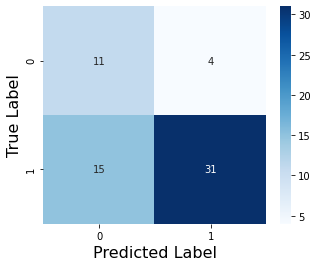

In [358]:
#ieq_and_sol.train_model(RandomForestClassifier(max_depth=4,n_estimators=10),features_to_include=["co2_median","rh_median","temperature_c_median"])
#ieq_and_sol.train_model(GaussianNB(),features_to_include=["co2_median","rh_median","temperature_c_median"])
ieq_and_sol.train_model(BernoulliNB(),features_to_include=["co2_median","rh_median","temperature_c_median"])
ieq_and_sol.predict()
ieq_and_sol.plot_confusion_matrix(save=True,target_label="sol_bw")

## IEQ and BW Restfulness

### Inspection

In [364]:
ieq_and_restful = ieq_and_sq_prediction(ieq_and_bw_binned, feature_list=["co2_median","rh_median","temperature_c_median"], target_list=["restful_binary"])
ieq_and_restful.target_summary("restful_binary")

0: 26
1: 158


### Adding Observations

In [365]:
add = get_artificial(ieq_and_bw_binned,"restful_binary",0)
ieq_and_restful.split_data("restful_binary")
ieq_and_restful.X_train = ieq_and_restful.X_train.append(add[["co2_median","rh_median","temperature_c_median"]])
ieq_and_restful.y_train = ieq_and_restful.y_train.append(add["restful_binary"])

### Modeling and Predicting

In [366]:
res = ieq_and_restful.optimize_models()
res

Highest Scoring Model:
	Model:	random_forest
	Score:	0.764
	Parameters:	{'max_depth': 3, 'n_estimators': 10}
	Number of Features:	3


,model,best_score,best_params,n_features
2,bnb,0.677011,{},1
5,bnb,0.683678,{},2
8,bnb,0.670345,{},3
1,gnb,0.730345,{},1
4,gnb,0.710345,{},2
7,gnb,0.683678,{},3
0,random_forest,0.730345,"{'max_depth': 2, 'n_estimators': 10}",1
3,random_forest,0.683678,"{'max_depth': 2, 'n_estimators': 10}",2
6,random_forest,0.764368,"{'max_depth': 3, 'n_estimators': 10}",3


RandomForestClassifier(max_depth=3, n_estimators=10)
Cross Validation Scores:
	0.7851851851851851
	0.7634615384615384
	0.9076923076923077
	0.49
	0.6551724137931034
Average:0.7203022890264268
Model Score: 0.8090584279108869


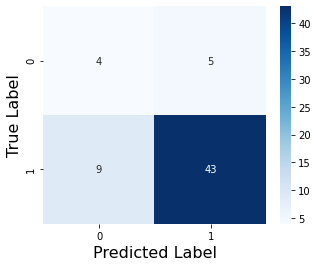

In [368]:
ieq_and_restful.train_model(RandomForestClassifier(max_depth=3,n_estimators=10),features_to_include=["co2_median","rh_median","temperature_c_median"])
#ieq_and_restful.train_model(BernoulliNB(),features_to_include=["co2_median","rh_median"])
#ieq_and_restful.train_model(GaussianNB(),features_to_include=["co2_median"])
ieq_and_restful.predict()
ieq_and_restful.plot_confusion_matrix(save=True,target_label="restful")

# Bonus Analysis: Fitbit-Measured Sleep on Self-Report Sleep

In [308]:
sleep = fb_targets.merge(right=bw_targets,left_on=["beiwe","end_date"],right_on=["beiwe","date"],suffixes=["_fb","_bw"])
sleep.dropna(inplace=True)
sleep.head()

,end_date,beiwe,efficiency,end_time,start_time,rem2nrem,tst_fb,waso,sol_fb,wol_fb,se_rating,se_binary,tst_binary_fb,waso_binary,rem2nrem_binary,date,tst,sol,naw,tst_binary_bw,restful_binary,sol_binary,naw_binary
0,2020-07-15,hcpu5myv,91.947566,2020-07-15 08:05:00,2020-07-14 23:11:00,0.312834,8.183333,42.5,0.5,0.0,3,1,1,1,1,2020-07-15,9.0,2.0,3.0,1,1,1,0
1,2020-07-18,hcpu5myv,90.773067,2020-07-18 08:03:00,2020-07-18 01:22:00,0.201320,6.066667,29.0,8.0,0.0,3,1,0,1,1,2020-07-18,7.0,5.0,1.0,0,1,1,1
2,2020-07-19,hcpu5myv,87.684729,2020-07-19 07:10:30,2020-07-19 00:24:00,0.227586,5.933333,49.5,0.5,0.0,2,1,0,1,1,2020-07-19,6.0,15.0,7.0,0,0,1,0
3,2020-07-20,hcpu5myv,91.596639,2020-07-20 06:19:30,2020-07-20 00:22:00,0.329268,5.450000,29.5,0.5,0.0,3,1,0,1,1,2020-07-20,6.0,5.0,3.0,0,1,1,0
4,2020-05-15,lkkjddam,84.630739,2020-05-15 12:53:30,2020-05-15 04:32:30,0.316770,7.066667,71.0,2.5,3.5,1,0,1,0,1,2020-05-15,8.0,60.0,3.0,1,0,0,0


Now we will see if various components of the Fitbit-measured sleep quality and predict how the participants will respond.

## TST

In [373]:
tst = ieq_and_sq_prediction(sleep, feature_list=["tst_binary_fb","rem2nrem_binary","waso_binary","se_binary"], target_list=["tst_binary_bw"])
tst.target_summary("tst_binary_bw")

1: 390
0: 675


In [383]:
tst = ieq_and_sq_prediction(sleep, feature_list=["tst_binary_fb","waso_binary","rem2nrem_binary","se_binary"], target_list=["tst_binary_bw"])
tst.split_data("tst_binary_bw")
res = tst.optimize_models()
res

Highest Scoring Model:
	Model:	random_forest
	Score:	0.746
	Parameters:	{'max_depth': 4, 'n_estimators': 10}
	Number of Features:	4


,model,best_score,best_params,n_features
2,bnb,0.729351,{},1
5,bnb,0.729351,{},2
8,bnb,0.715355,{},3
11,bnb,0.729351,{},4
1,gnb,0.729351,{},1
4,gnb,0.729351,{},2
7,gnb,0.729351,{},3
10,gnb,0.739151,{},4
0,random_forest,0.729351,"{'max_depth': 2, 'n_estimators': 5}",1
3,random_forest,0.729351,"{'max_depth': 2, 'n_estimators': 5}",2


BernoulliNB()
Cross Validation Scores:
	0.7318729463307777
	0.785515873015873
	0.6726294928542119
	0.7888175829168559
	0.7101310730142545
Average:0.7377933936263947
Model Score: 0.7450800774401819


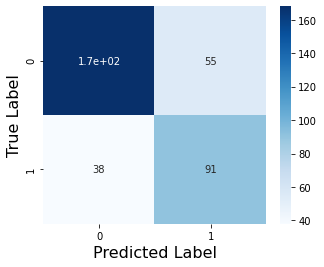

In [385]:
#tst.train_model(RandomForestClassifier(max_depth=4,n_estimators=10),features_to_include=["tst_binary_fb","rem2nrem_binary","waso_binary","se_binary"])
#tst.train_model(GaussianNB(),features_to_include=["tst_binary_fb","rem2nrem_binary","waso_binary","se_binary"])
tst.train_model(BernoulliNB(),features_to_include=["tst_binary_fb"])
tst.predict()
tst.plot_confusion_matrix(save=True,target_label="tst_bw")

## Restful

In [311]:
rest = ieq_and_sq_prediction(sleep, feature_list=["waso_binary","se_binary","rem2nrem_binary","tst_binary_fb"], target_list=["restful_binary"])
rest.target_summary("restful_binary")
rest.split_data("restful_binary")
add = get_artificial(sleep,"restful_binary",0,features=["tst_binary_fb","rem2nrem_binary","waso_binary","se_binary"])
rest.split_data("restful_binary")
rest.X_train = rest.X_train.append(add[["tst_binary_fb","rem2nrem_binary","waso_binary","se_binary"]])
rest.y_train = rest.y_train.append(add["restful_binary"])
res = rest.optimize_models()
res

1: 841
0: 224
Highest Scoring Model:
	Model:	random_forest
	Score:	0.609
	Parameters:	{'max_depth': 2, 'n_estimators': 5}
	Number of Features:	2


,model,best_score,best_params,n_features
2,bnb,0.600853,{},1
5,bnb,0.599784,{},2
8,bnb,0.599784,{},3
11,bnb,0.578393,{},4
1,gnb,0.600853,{},1
4,gnb,0.570901,{},2
7,gnb,0.581585,{},3
10,gnb,0.577330,{},4
0,random_forest,0.600853,"{'max_depth': 2, 'n_estimators': 5}",1
3,random_forest,0.609404,"{'max_depth': 2, 'n_estimators': 5}",2


RandomForestClassifier(max_depth=2, n_estimators=5)
Cross Validation Scores:
	0.564887572533849
	0.6298447383553767
	0.6525453941206684
	0.7676280646386723
	0.5191279308926368
Average:0.6268067401082407
Model Score: 0.7098791695030633


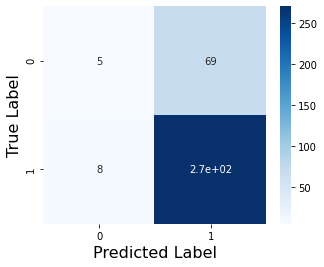

In [312]:
rest.train_model(RandomForestClassifier(max_depth=2,n_estimators=5),features_to_include=["waso_binary","se_binary"])
rest.predict()
rest.plot_confusion_matrix()

## NAW

In [313]:
naw = ieq_and_sq_prediction(sleep, feature_list=["waso_binary","se_binary","tst_binary_fb","rem2nrem_binary"], target_list=["naw_binary"])
naw.target_summary("naw_binary")

0: 517
1: 548


In [314]:
naw.split_data("naw_binary")
naw.split_data("naw_binary")
res = naw.optimize_models()
res

Highest Scoring Model:
	Model:	random_forest
	Score:	0.579
	Parameters:	{'max_depth': 2, 'n_estimators': 5}
	Number of Features:	1


,model,best_score,best_params,n_features
2,bnb,0.579248,{},1
5,bnb,0.579248,{},2
8,bnb,0.579248,{},3
11,bnb,0.570797,{},4
1,gnb,0.579248,{},1
4,gnb,0.579248,{},2
7,gnb,0.579248,{},3
10,gnb,0.569398,{},4
0,random_forest,0.579248,"{'max_depth': 2, 'n_estimators': 5}",1
3,random_forest,0.579248,"{'max_depth': 2, 'n_estimators': 10}",2


BernoulliNB()
Cross Validation Scores:
	0.5603798162621692
	0.6235332464146024
	0.5697849320490829
	0.5763199888989108
	0.5962013733890899
Average:0.5852438714027711
Model Score: 0.5903724747474748


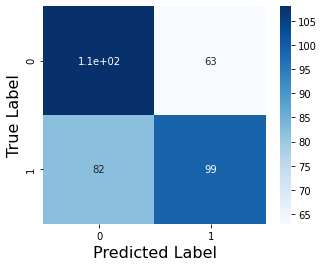

In [315]:
naw.train_model(BernoulliNB(),features_to_include=["waso_binary","se_binary"])
naw.predict()
naw.plot_confusion_matrix()